In [1]:
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
import warnings
from string import digits
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import (
    wordnet,
    stopwords
)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Savio Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
train = pd.read_csv('./data/train.csv', index_col ="tweet_id")
test = pd.read_csv('./data/test.csv', index_col ="tweet_id")

In [3]:
train.head()

,tweet,sentiment
tweet_id,,
1701,#sxswnui #sxsw #apple defining language of tou...,1
1851,Learning ab Google doodles! All doodles should...,1
2689,one of the most in-your-face ex. of stealing t...,2
4525,This iPhone #SXSW app would b pretty awesome i...,0
3604,Line outside the Apple store in Austin waiting...,1


In [4]:
test.head()

,tweet
tweet_id,
7506,Audience Q: What prototyping tools do you use?...
7992,At SXSW? Send Your Best Photos &amp; Videos to...
247,@mention and here's a pic of you winning your...
7688,Google Marissa Mayer: mobile phone as a cursor...
3294,#SXSW Google maps is even cooler than I thought


In [5]:
def remove_pattern(input_txt, pattern):
#     print(input_txt)
#     print(pattern)
    r = re.findall(pattern, input_txt)
    for x in r:
        input_txt = re.sub(x, '', input_txt)
    return input_txt

def remove_digits(str_txt):
    remove_digits = str.maketrans('', '', digits)
    str_txt = str_txt.translate(remove_digits)
    return str_txt

# function to remove non-ASCII
def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)
 


def data_cleaning(table):
    #Put everything in lower case
    #table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(remove_non_ascii)
    #Replace @<some_user>
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "@[\w]*"))
    #replace 'link'
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "link"))
    #replace 'quot'
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "quot"))
    #replace '#'
    #table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "#[\w]*"))
    #Replace RT:rt
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "RT"))
    #Remove URL's
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "r'^https?:\/\/.*[\r\n]*'"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "r'^http?:\/\/.*[\r\n]*'"))
    #Remove Numbers "I do not think we should remove numbers"
    table['tweet'] = (table['tweet'].apply(lambda x: " ".join([i for i in x.split(" ") if not i.replace(".","").isnumeric()])))
    #table['tweet'] = table['tweet'].apply(lambda row:remove_digits(row))
    #Remove Special Characters & Punctuantions
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "#"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "_"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "&;"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "&gt;"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "&lt;"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "{}"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, 'r"[^a-zA-Z0-9]"'))
    table['tweet'] = table['tweet'].replace(r'https?://\S+|www\.\S+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'["!$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'#([^\s]+)', r'\1', regex=True)
    return table

In [7]:
#remove Null rows if any
def remove_na(table):
    table = table.dropna()
    return table

In [6]:
#Tokenize the data
def data_tokenize(table):
    tokenizer = RegexpTokenizer(r'\w+')
    table['tweet_tokenize'] = table['tweet'].apply(lambda row:tokenizer.tokenize(row))
    return table

In [7]:
from nltk.corpus import stopwords
#Removing Stop Words
def remove_stop_words(table):
    en_stop = set(stopwords.words('english'))
    table['tweet_tokenize'] = table['tweet_tokenize'].apply(lambda x:[word for word in x if not word in en_stop] )
    return table

In [8]:
#Lemmatizing the words
def lemmatize_words(table):
    lemma = WordNetLemmatizer()
    table['tweet_tokenize'] = table['tweet_tokenize'].apply(lambda x: [lemma.lemmatize(word) for word in x])
    return table

In [9]:
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [10]:
#Removing and replacing contractions eg. wasn't, couldn't, shouldn't....etc
import contractions
def remove_replace_contractions(row):
    str_fixed = contractions.fix(row)
    return str_fixed

In [12]:
#remove Null rows if any
def remove_na(table):
    table = table.dropna()
    return table

In [13]:
train = remove_na(train)
train = data_cleaning(train)
train['tweet'] = train['tweet'].apply(lambda x: detect_elongated_words(x))
train['tweet'] = train['tweet'].apply(lambda x: remove_replace_contractions(x))

In [14]:
train = data_tokenize(train)
train = remove_stop_words(train)
train = lemmatize_words(train)

In [15]:
train.head(50)

,tweet,sentiment
tweet_id,,
1701,sxswnui sxsw apple defining language of touch ...,1
1851,Learning ab Google doodles! All doodles should...,1
2689,one of the most inyourface ex of stealing the ...,2
4525,This iPhone SXSW ap would b pretty awesome if ...,0
3604,Line outside the Apple store in Austin waiting...,1
966,technews One lone dude awaits iPad at Apples S...,1
1395,SXSW Tips Prince NPR Videos Toy Shopping With ...,1
8182,NU user New UberSocial for iPhone now in the...,1
8835,Free SXSW sampler on iTunes FreMusic,2


In [19]:
def plot_wordcloud(table):
    # all the tweets
    #all_words = ' '.join([text for text in table['tweet_tokenize']])
    all_words = ''
    for text in table['tweet_tokenize']:
        temp = ' '.join(text)
        all_words = temp +' '+all_words
        temp = ''
    # generate wordcloud object
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    # plot wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

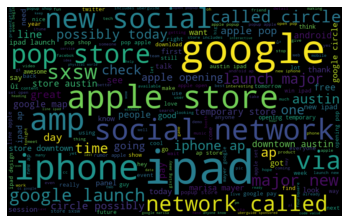

In [20]:
#Plotting wordcloud of most used words
plot_wordcloud(train)

In [21]:
def plot_wordcloud_sentiment(table, target_value):
    # all the tweets
    #all_words = ' '.join([text for text in table['tweet_tokenize']])
    all_words = ''
    temp_table = table['tweet_tokenize'][table['sentiment'] == target_value]
    print(temp_table.shape)
    for text in temp_table:
        temp = ' '.join(text)
        all_words = temp +' '+all_words
        temp = ''
    # generate wordcloud object
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    # plot wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

(456,)


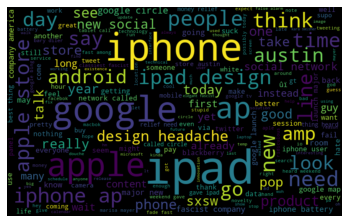

In [22]:
# negative tweets
plot_wordcloud_sentiment(train, 0)

(4310,)


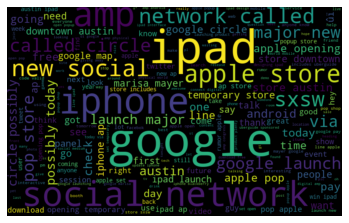

In [23]:
# neutral tweets
plot_wordcloud_sentiment(train, 1)

(2382,)


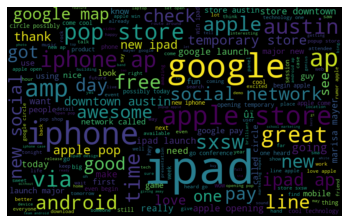

In [24]:
# Positive tweets
plot_wordcloud_sentiment(train, 2)